In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as wg
from IPython.display import display

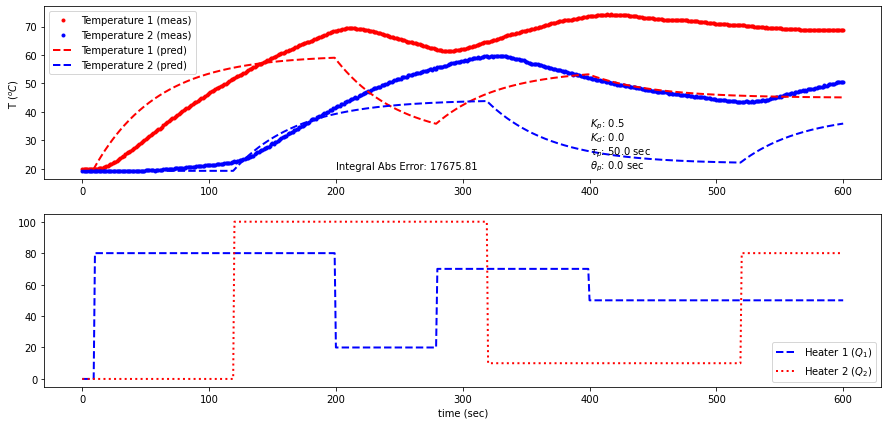

FOPDT Simulator: Adjust Kp, Kd, taup, and thetap to achieve lowest Integral Abs Error


In [2]:
n = 601 # time points to plot
tf = 600.0 # final time

# TCLab FOPDT
Kp = 1.1
Kd = 0.65
taup = 190.0
thetap = 25.0
T1_0 = 21.3
T2_0 = 21.3
y0 = [T1_0,T2_0]
Kff = -Kd/Kp

def process(y,t,u1,u2):
    y1,y2 = y
    dy1dt = (1.0/taup) * (-(y1-y0[0]) + Kp * u1 + Kd * (y2-y1))
    dy2dt = (1.0/taup) * (-(y2-y0[1]) + (Kp/2.0) * u2 + Kd * (y1-y2))
    return [dy1dt,dy2dt]

def pidPlot(Kc,tauI,tauD,Kff):
    y0 = [23.0,23.0]
    t = np.linspace(0,tf,n) # create time vector
    P1 = np.zeros(n)         # initialize proportional term
    I1 = np.zeros(n)         # initialize integral term
    D1 = np.zeros(n)         # initialize derivative term
    FF1 = np.zeros(n)        # initialize feedforward term
    e1 = np.zeros(n)         # initialize error
    P2 = np.zeros(n)         # initialize proportional term
    I2 = np.zeros(n)         # initialize integral term
    D2 = np.zeros(n)         # initialize derivative term
    FF2 = np.zeros(n)        # initialize feedforward term
    e2 = np.zeros(n)         # initialize error
    OP1 = np.zeros(n)       # initialize controller output
    OP2 = np.zeros(n)       # initialize disturbance
    PV1 = np.ones(n)*y0[0]  # initialize process variable
    PV2 = np.ones(n)*y0[1]  # initialize process variable
    SP1 = np.ones(n)*y0[0]  # initialize setpoint
    SP2 = np.ones(n)*y0[1]  # initialize setpoint
    SP1[10:] = 60.0         # step up
    SP1[400:] = 40.0         # step up
    SP2[150:] = 50.0        # step down
    SP2[350:] = 35.0        # step down
    Kc1 = Kc
    Kc2 = Kc*2.0
    Kff1 = Kff
    Kff2 = Kff*2.0
    iae = 0.0
    # loop through all time steps
    for i in range(1,n):
        # simulate process for one time step
        ts = [t[i-1],t[i]]         # time interval
        heaters = (OP1[max(0,i-int(thetap))],OP2[max(0,i-int(thetap))])
        y = odeint(process,y0,ts,args=heaters)
        y0 = y[1]                  # record new initial condition
        # calculate new OP with PID
        PV1[i] = y[1][0]              # record T1 PV
        PV2[i] = y[1][1]              # record T2 PV
        iae += np.abs(SP1[i]-PV1[i]) + np.abs(SP2[i]-PV2[i])
        dt = t[i] - t[i-1]         # calculate time step

        # PID for loop 1
        e1[i] = SP1[i] - PV1[i]       # calculate error = SP - PV
        P1[i] = Kc1 * e1[i]           # calculate proportional term
        I1[i] = I1[i-1] + (Kc1/tauI) * e1[i] * dt  # calculate integral term
        D1[i] = -Kc * tauD * (PV1[i]-PV1[i-1])/dt # calculate derivative
        FF1[i] = Kff1 * (PV2[i]-PV1[i])
        OP1[i] = P1[i] + I1[i] + D1[i] + FF1[i] # calculate new output
        if OP1[i]>=100:
            OP1[i] = 100.0
            I1[i] = I1[i-1] # reset integral
        if OP1[i]<=0:
            OP1[i] = 0.0
            I1[i] = I1[i-1] # reset integral            

        # PID for loop 2
        e2[i] = SP2[i] - PV2[i]       # calculate error = SP - PV
        P2[i] = Kc2 * e2[i]           # calculate proportional term
        I2[i] = I2[i-1] + (Kc2/tauI) * e2[i] * dt  # calculate integral term
        D2[i] = -Kc2 * tauD * (PV2[i]-PV2[i-1])/dt # calculate derivative
        FF2[i] = Kff2 * (PV1[i]-PV2[i])
        OP2[i] = P2[i] + I2[i] + D2[i] + FF2[i] # calculate new output
        if OP2[i]>=100:
            OP2[i] = 100.0
            I2[i] = I2[i-1] # reset integral
        if OP2[i]<=0:
            OP2[i] = 0.0
            I2[i] = I2[i-1] # reset integral            

    # plot PID response
    plt.figure(1,figsize=(15,7))
    plt.subplot(2,2,1)
    plt.plot(t,SP1,'k-',linewidth=2,label='Setpoint 1 (SP)')
    plt.plot(t,PV1,'r:',linewidth=2,label='Temperature 1 (PV)')
    plt.ylabel(r'T $(^oC)$')
    plt.text(100,35,'Integral Abs Error: ' + str(np.round(iae,2)))
    plt.text(400,35,r'$K_{c1}$: ' + str(np.round(Kc,1)))  
    plt.text(400,30,r'$\tau_I$: ' + str(np.round(tauI,0)) + ' sec')  
    plt.text(400,25,r'$\tau_D$: ' + str(np.round(tauD,0)) + ' sec')  
    plt.text(400,20,r'$K_{ff}$: ' + str(np.round(Kff1,2)))  
    plt.ylim([15,70])
    plt.legend(loc=1)
    plt.subplot(2,2,2)
    plt.plot(t,SP2,'k-',linewidth=2,label='Setpoint 2 (SP)')
    plt.plot(t,PV2,'r:',linewidth=2,label='Temperature 2 (PV)')
    plt.ylabel(r'T $(^oC)$')
    plt.text(20,65,r'$K_{c2}$: ' + str(np.round(Kc*2,1)))  
    plt.text(20,60,r'$\tau_I$: ' + str(np.round(tauI,0)) + ' sec')  
    plt.text(20,55,r'$\tau_D$: ' + str(np.round(tauD,0)) + ' sec')  
    plt.text(20,50,r'$K_{ff}$: ' + str(np.round(Kff2,2)))
    plt.ylim([15,70])
    plt.legend(loc=1)
    plt.subplot(2,2,3)
    plt.plot(t,OP1,'b--',linewidth=2,label='Heater 1 (OP)')
    plt.legend(loc='best')
    plt.xlabel('time (sec)')
    plt.subplot(2,2,4)
    plt.plot(t,OP2,'b--',linewidth=2,label='Heater 2 (OP)')
    plt.legend(loc='best')
    plt.xlabel('time (sec)')

print('PID with Feedforward Simulator: Adjust Kc, tauI, tauD, and Kff ' + \
      'to achieve lowest Integral Abs Error')

# ITAE Setpoint Tracking PI Tuning
Kc = (0.586/Kp)*(thetap/taup)**(-0.916); tauI = taup/(1.03-0.165*(thetap/taup))
print(f'ITAE Recommended: Kc={Kc:4.2f}, tauI={tauI:5.1f}, tauD=0, Kff={Kff:4.2f}')

# IMC Aggressive PID Tuning
tauc = max(0.1*taup,0.8*thetap); Kc = (1/Kp)*(taup+0.5*taup)/(tauc+0.5*thetap)
tauI = taup+0.5*thetap; tauD = taup*thetap/(2*taup+thetap); Kff=-Kd/Kp
print(f'IMC Recommended: Kc={Kc:4.2f}, tauI={tauI:5.1f}, tauD={tauD:4.2f}, Kff={Kff:4.2f}')

Kc_slide = wg.FloatSlider(value=Kc,min=0.0,max=50.0,step=1.0)
tauI_slide = wg.FloatSlider(value=tauI,min=20.0,max=250.0,step=1.0)
tauD_slide = wg.FloatSlider(value=tauD,min=0.0,max=20.0,step=1.0)
Kff_slide = wg.FloatSlider(value=Kff,min=-0.5,max=0.5,step=0.1)
wg.interact(pidPlot, Kc=Kc_slide, tauI=tauI_slide, tauD=tauD_slide,Kff=Kff_slide)
print('')